## $\textbf{Inferring Musical Time Signature via Apple Watch Logs of Conductor Wrist Motion}$

$\textbf{Author:}\text{ Ryan Burns}$

$\text{This notebook is dedicated to analysis of componentwise spectrograms as input feature to deep learning classification models.}$

$\textbf{Motion Class Labels:}$

$\text{All class labels are defined for a right-handed user. An orchestral conductor varies their baton pattern according to 1 of 4 possible states, }$
$\text{comprised of 3 time signature classes and a resting class (i.e., cessation of baton motion).}$

$\text{0 }\leftrightarrow [1\enspace0\enspace0\enspace0]\leftrightarrow \text{REST}\Longrightarrow\text{conductor has ceased baton motion (no conducting)}$

$\text{1 }\leftrightarrow [0\enspace1\enspace0\enspace0]\leftrightarrow {2/4}\Longrightarrow\text{conductor proceeds with baton motion consistent with a }\mathbf{\genfrac{}{}{0pt}{}{2}{4}}\text{ time signature}$

$\text{2 }\leftrightarrow [0\enspace0\enspace1\enspace0]\leftrightarrow {3/4}\Longrightarrow\text{conductor proceeds with baton motion consistent with a }\mathbf{\genfrac{}{}{0pt}{}{3}{4}}\text{ time signature}$

$\text{3 }\leftrightarrow [0\enspace0\enspace0\enspace1]\leftrightarrow {4/4}\Longrightarrow\text{conductor proceeds with baton motion consistent with a }\mathbf{\genfrac{}{}{0pt}{}{4}{4}}\text{ time signature}$

$\text{For more information on musical time signatures, visit: }\textit{https://en.wikipedia.org/wiki/Time_signature}.$

![title](baton_motion.png)

$\text{The baton patterns for each time signature of interest are depicted diagramatically above. We assume a tech enthusiast conductor who desires}$
$\text{an Apple Watch app/experience for automatic discrimination between the 3 time signatures above, in addition to a catch-all }\textit{at-rest}\text{ state. We }$
$\text{also assume that this conductor would like automatic time-signature inference to be as tempo-agnostic as possible. Be it }\textit{largo}\text{ or }\textit{prestissimo}\text{,}$
$\text{we assume that the tempo of the musical composition of question would not fool the ideal baton pattern classifier. As such, while the amount}$
$\text{of data collected for this analysis is still limited in its size and diversity (i.e., we can assume overfit models), efforts have been made during}$
$\text{data collection to vary the tempo across each time signature's constituent wrist motion observations. The duration (in seconds or measures)}$
$\text{of each time signature's wrist motion subsequence is also varied during collection. We create an aggregated dataset of independent concatenated}$
$\text{collects for supervised learning in the code below.}$

$\textbf{Note On Labeling:}$

$\text{SensorLog labels are recorded in real time using the app's class label buttons for a streaming iPhone. This iPhone logs data concurrently with}$
$\text{an Apple Watch, which also reports its own class labels. Since toggling of the Apple Watch's class labels using the SensorLog UI on the watch }$
$\text{face would interfere with data collection of wrist motion, we use the }\textit{iPhone}\text{ to log wrist motion labels. By time-aligning the iPhone and Apple}$
$\text{Watch streams below (i.e., using POSIX timestamps), we can readily provide wrist motion labels for the Apple Watch motion signals without}$
$\text{interfering with their trajectory as just described. In short, real-time motion labeling is available through dual stream of Apple Watch }$
$\text{iPhone data, where the former provides the motion observations of interest and the latter provides a mechanism for real-time motion labeling.}$

### $\textbf{Import Packages}$

In [1]:
import pandas as pd
from os import getcwd, environ;
from itertools import product as iter_prod;
from matplotlib import pyplot as plt;
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import array, hstack, argmax, ones, zeros, log10;
from numpy import logical_or, logical_not, expand_dims, flip;
from numpy import  abs, arange, shape, newaxis, sum, flipud;
from numpy import nan_to_num, transpose;
from scipy.signal import spectrogram;

from tensorflow.keras.models import Sequential, Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import CategoricalAccuracy;
from tensorflow.keras.metrics import Precision, Recall, AUC;
from tensorflow.keras.layers import Dropout, LSTM, Dense, Conv2D;
from tensorflow.keras.layers import Conv2D, Reshape, Conv1D;
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D;
from tensorflow.keras.layers import Input, GaussianNoise, ConvLSTM2D;
from sklearn.metrics import confusion_matrix;

from SensorLogUtils import convert_iPhone_units;

environ['KMP_DUPLICATE_LIB_OK']='True'

### $\textbf{Class Label Definitions}$

In [2]:
# Ordinal motion class labels
class_table = pd.DataFrame({
    'REST': {
        'id': 'REST', 
        'description': 'no conducting / baton pattern',
        '1-hot label': [1,0,0,0],
        'ordinal label': 0
    },
    '2/4': {
        'id': '2/4', 
        'description': 'conducting pattern for a 2/4 time signature',
        '1-hot label': [0,1,0,0],
        'ordinal label': 1
    },
    '3/4': {
        'id': '3/4', 
        'description':'conducting pattern for a 3/4 time signature',
        '1-hot label': [0,0,1,0],
        'ordinal label': 2
    },
    '4/4': {
        'id': '4/4', 
        'description':'conducting pattern for a 4/4 time signature',
        '1-hot label': [0,0,0,1],
        'ordinal label': 3
    }
});

# Number of classes
C = 4;

# Print class table
class_table

,REST,2/4,3/4,4/4
id,REST,2/4,3/4,4/4
description,no conducting / baton pattern,conducting pattern for a 2/4 time signature,conducting pattern for a 3/4 time signature,conducting pattern for a 4/4 time signature
1-hot label,"[1, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 1]"
ordinal label,0,1,2,3


### $\textbf{Specify & Load Dataset}$

In [3]:
################
# Specify data #
################

# Specify local data storage path
data_path = getcwd() + '/data';

# Collect file string ID
collect_IDs = [
    'time_signatures_collect1',
    'time_signatures_collect2'
];

# Build string filename corresponding to collect_ID
collect_files = [
    (data_path + '/labeled_' + collect_ID + '_appleWatch.csv')
for collect_ID in collect_IDs];

#############
# Load data #
#############

# Load and concatenate dataframes for all
# labeled collects in list collect_IDs
df = pd.concat([pd.read_csv(f, 
    error_bad_lines=False,
    warn_bad_lines=False)
    for f in collect_files
],axis=0,ignore_index=True);

# Data fields (column headers)
fields = [fd for fd in df];

# Length of dataframe
N = len(df); # (samples)

### $\textbf{Select IMU Data & 1-Hot Class Labels}$

In [4]:
# Select input signals
x = nan_to_num(array(df[[
    'accelerometerAccelerationX(m/s^2)',
    'accelerometerAccelerationY(m/s^2)',
    'accelerometerAccelerationZ(m/s^2)',
    'motionRotationRateX(rad/s)',
    'motionRotationRateY(rad/s)',
    'motionRotationRateZ(rad/s)'
]]));

# Define 1-hot labels
y = nan_to_num(array(df[[
    
    # List all class headers in table above
    class_name for class_name in class_table
]]));

### $\textbf{Specify Sliding Observation Window Parameters}$

In [5]:
# Number of raw sensor samples (N)
# and their dimensionality (D)
N, D = shape(x);

# Sliding obs. window length
M = 1024; # (samples)

# Step size of obs. window
m = 4;  # (samples)

# Linear grid for sliding observation
# window reflecting window length & step
# size specified above, mapped to raw
# sensor samples n = M, M + m, M + 2m, ...
obs_idx = [n for n in range(M,N,m)];

### $\textbf{Define Observations & Class Labels}$

In [6]:
# Windowed 6D spectrogram observation sequence input to model
X = (array([[spectrogram(x[(n - M):n,d],
    window='blackmanharris',fs=100,
    nperseg=int(M/4),nfft=M)[2] 
    for d in range(D)] for n in obs_idx
]));

# Overwrite N,M,D with new dimensionality
N,K,M,D = shape(X);

# Ground truth 1-hot window-resolution class labels
Y = array([
    [1 if c == argmax(sum(y[(n - M):n,:],0)) 
    else 0 for c in range(C)] for n in obs_idx]);

### $\textbf{Training Parameters}$

In [7]:
# Fraction of dataset to hold 
# out for model validation
pct_validation = 0.2;

# Total number of obs.
N_obs = len(X);

# Number of training epochs
N_epoch = 200;

# Number of batches
N_batch = int(N_obs / 3);

### $\textbf{Define Machine Learning Model}$

In [8]:
#####################################################
# Define model architecture w/ Keras functional API #
#####################################################

# Input layer - M x D observation window
input_layer = Input((K,M,D));

# Add Gaussian noise to M x D input
h0 = GaussianNoise(1e-4)(input_layer);

# Convolutional layer
h1 = Conv2D(filters=256,
    kernel_size=(K,M),
    activation='relu')(h0);

# # Averge pooling layer
h2 = AveragePooling2D(pool_size=(1,1))(h1);

# Dense hyperbolic tangent activation layer
h3 = Dense(64,activation='tanh')(h2);

# Dropout (25%)
h4 = Dropout(0.25)(h3);

# Reshape layer
h5 = Reshape((64,1))(h4);

# 1D convolutional layer
h6 = Conv1D(64,1,activation='tanh')(h5);

# Averge pooling layer
h7 = AveragePooling1D(pool_size=(8))(h6);

# Long short-term memory layer
h8 = LSTM(C*C,activation='tanh',
    dropout=0.5,
    recurrent_dropout=0.5)(h7);

# Output layer - C x 1 softmax class activation 
output_layer = Dense(C,activation='softmax')(h8);

# Set up Keras Model() instance
model = Model(
    inputs=input_layer,  # Model inputs
    outputs=output_layer # Model outputs
);

###########################
# Define loss & optimizer #
###########################

# Set RMSprop optimization for 
# speed-of-convergence purposes
opt = RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.001,
    epsilon=1e-07,
    name="RMSprop"
);

# Model compilation, using categorical
# cross-entropy error w/ RMSprop
model.compile(
    
    # Error/loss function
    loss='categorical_crossentropy', 
    
    # Use RMSprop
    optimizer=opt,
    
    # List metrics here
    metrics=[
        CategoricalAccuracy(),
        AUC(),
        Precision(),
        Recall()
    ]
);

# Print a summary table
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 513, 4)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 6, 513, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 256)         3152128   
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 256)         0         
_________________________________________________________________
dense (Dense)                (None, 1, 1, 64)          16448     
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 64)          0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 1)             0     

### $\textbf{Train Machine Learning Model}$

In [9]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # windowed observations
    y=Y, # 1-hot motion class labels
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=pct_validation,
    
    # False for time series
    shuffle=False,
    
    # Other misc params
    sample_weight=None,
    validation_freq=1,
    max_queue_size=10,
    
    # Parallelize job across 2 workers
    workers=2,
    use_multiprocessing=True
);

Train on 16236 samples, validate on 4060 samples
Epoch 1/200
16236/16236 [==============================] - 22s 1ms/sample - loss: 1.3668 - categorical_accuracy: 0.3044 - auc: 0.5885 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3087 - val_categorical_accuracy: 0.4084 - val_auc: 0.7127 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
16236/16236 [==============================] - 20s 1ms/sample - loss: 1.3120 - categorical_accuracy: 0.3815 - auc: 0.6811 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.2469 - val_categorical_accuracy: 0.4966 - val_auc: 0.7390 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
16236/16236 [==============================] - 21s 1ms/sample - loss: 1.2697 - categorical_accuracy: 0.4174 - auc: 0.7113 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1808 - val_categorical_accuracy: 0.5315 - val_auc: 0.7930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
16236/16236 [==============

Epoch 29/200
16236/16236 [==============================] - 18s 1ms/sample - loss: 0.6730 - categorical_accuracy: 0.6927 - auc: 0.9219 - precision: 0.8131 - recall: 0.4576 - val_loss: 0.7373 - val_categorical_accuracy: 0.6970 - val_auc: 0.9092 - val_precision: 0.8120 - val_recall: 0.3680
Epoch 30/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.6509 - categorical_accuracy: 0.6936 - auc: 0.9255 - precision: 0.8040 - recall: 0.4816 - val_loss: 0.7529 - val_categorical_accuracy: 0.6931 - val_auc: 0.9054 - val_precision: 0.7946 - val_recall: 0.3850
Epoch 31/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.6612 - categorical_accuracy: 0.6891 - auc: 0.9229 - precision: 0.8046 - recall: 0.4815 - val_loss: 0.8087 - val_categorical_accuracy: 0.6714 - val_auc: 0.8961 - val_precision: 0.9293 - val_recall: 0.2815
Epoch 32/200
16236/16236 [==============================] - 19s 1ms/sample - loss: 0.7044 - categorical_accuracy: 0.6666 - auc: 0.909

16236/16236 [==============================] - 17s 1ms/sample - loss: 0.4885 - categorical_accuracy: 0.7189 - auc: 0.9435 - precision: 0.7705 - recall: 0.6245 - val_loss: 0.6249 - val_categorical_accuracy: 0.7401 - val_auc: 0.9308 - val_precision: 0.8612 - val_recall: 0.4525
Epoch 58/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.4874 - categorical_accuracy: 0.7192 - auc: 0.9438 - precision: 0.7702 - recall: 0.6273 - val_loss: 0.6377 - val_categorical_accuracy: 0.7330 - val_auc: 0.9297 - val_precision: 0.8634 - val_recall: 0.4576
Epoch 59/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.5086 - categorical_accuracy: 0.7101 - auc: 0.9399 - precision: 0.7601 - recall: 0.6165 - val_loss: 0.6414 - val_categorical_accuracy: 0.7300 - val_auc: 0.9260 - val_precision: 0.8549 - val_recall: 0.4919
Epoch 60/200
16236/16236 [==============================] - 18s 1ms/sample - loss: 0.4883 - categorical_accuracy: 0.7140 - auc: 0.9424 - precision

16236/16236 [==============================] - 17s 1ms/sample - loss: 0.4532 - categorical_accuracy: 0.7432 - auc: 0.9520 - precision: 0.7913 - recall: 0.6725 - val_loss: 0.6058 - val_categorical_accuracy: 0.8022 - val_auc: 0.9490 - val_precision: 0.8769 - val_recall: 0.6653
Epoch 86/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.4454 - categorical_accuracy: 0.7502 - auc: 0.9547 - precision: 0.7975 - recall: 0.6798 - val_loss: 0.6172 - val_categorical_accuracy: 0.8121 - val_auc: 0.9495 - val_precision: 0.8570 - val_recall: 0.7512
Epoch 87/200
16236/16236 [==============================] - 19s 1ms/sample - loss: 0.4450 - categorical_accuracy: 0.7652 - auc: 0.9575 - precision: 0.8059 - recall: 0.6981 - val_loss: 0.5892 - val_categorical_accuracy: 0.8032 - val_auc: 0.9522 - val_precision: 0.8629 - val_recall: 0.7552
Epoch 88/200
16236/16236 [==============================] - 18s 1ms/sample - loss: 0.4329 - categorical_accuracy: 0.7838 - auc: 0.9622 - precision

16236/16236 [==============================] - 17s 1ms/sample - loss: 0.2606 - categorical_accuracy: 0.9302 - auc: 0.9906 - precision: 0.9347 - recall: 0.9265 - val_loss: 0.4561 - val_categorical_accuracy: 0.8611 - val_auc: 0.9612 - val_precision: 0.8660 - val_recall: 0.8599
Epoch 114/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.2472 - categorical_accuracy: 0.9341 - auc: 0.9917 - precision: 0.9373 - recall: 0.9313 - val_loss: 0.5429 - val_categorical_accuracy: 0.7958 - val_auc: 0.9523 - val_precision: 0.8007 - val_recall: 0.7919
Epoch 115/200
16236/16236 [==============================] - 18s 1ms/sample - loss: 0.2464 - categorical_accuracy: 0.9314 - auc: 0.9912 - precision: 0.9355 - recall: 0.9276 - val_loss: 0.5411 - val_categorical_accuracy: 0.8204 - val_auc: 0.9504 - val_precision: 0.8225 - val_recall: 0.8182
Epoch 116/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.3433 - categorical_accuracy: 0.8716 - auc: 0.9773 - precis

16236/16236 [==============================] - 17s 1ms/sample - loss: 0.1183 - categorical_accuracy: 0.9722 - auc: 0.9978 - precision: 0.9734 - recall: 0.9714 - val_loss: 0.4651 - val_categorical_accuracy: 0.8756 - val_auc: 0.9598 - val_precision: 0.8780 - val_recall: 0.8741
Epoch 142/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.1193 - categorical_accuracy: 0.9720 - auc: 0.9975 - precision: 0.9739 - recall: 0.9710 - val_loss: 0.5017 - val_categorical_accuracy: 0.8599 - val_auc: 0.9560 - val_precision: 0.8608 - val_recall: 0.8591
Epoch 143/200
16236/16236 [==============================] - 18s 1ms/sample - loss: 0.1731 - categorical_accuracy: 0.9437 - auc: 0.9942 - precision: 0.9451 - recall: 0.9424 - val_loss: 0.6905 - val_categorical_accuracy: 0.7921 - val_auc: 0.9382 - val_precision: 0.7958 - val_recall: 0.7901
Epoch 144/200
16236/16236 [==============================] - 18s 1ms/sample - loss: 0.2430 - categorical_accuracy: 0.9117 - auc: 0.9884 - precis

16236/16236 [==============================] - 17s 1ms/sample - loss: 0.0548 - categorical_accuracy: 0.9905 - auc: 0.9993 - precision: 0.9908 - recall: 0.9901 - val_loss: 0.5309 - val_categorical_accuracy: 0.8685 - val_auc: 0.9598 - val_precision: 0.8693 - val_recall: 0.8682
Epoch 170/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.0968 - categorical_accuracy: 0.9743 - auc: 0.9973 - precision: 0.9748 - recall: 0.9738 - val_loss: 1.0935 - val_categorical_accuracy: 0.7059 - val_auc: 0.9128 - val_precision: 0.7069 - val_recall: 0.7047
Epoch 171/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.4126 - categorical_accuracy: 0.8697 - auc: 0.9719 - precision: 0.8712 - recall: 0.8686 - val_loss: 0.5658 - val_categorical_accuracy: 0.8623 - val_auc: 0.9508 - val_precision: 0.8631 - val_recall: 0.8606
Epoch 172/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.1091 - categorical_accuracy: 0.9685 - auc: 0.9970 - precis

16236/16236 [==============================] - 17s 1ms/sample - loss: 0.1262 - categorical_accuracy: 0.9625 - auc: 0.9961 - precision: 0.9634 - recall: 0.9621 - val_loss: 1.4594 - val_categorical_accuracy: 0.6512 - val_auc: 0.8985 - val_precision: 0.6533 - val_recall: 0.6502
Epoch 198/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.3601 - categorical_accuracy: 0.8975 - auc: 0.9797 - precision: 0.8985 - recall: 0.8967 - val_loss: 0.5395 - val_categorical_accuracy: 0.8690 - val_auc: 0.9613 - val_precision: 0.8689 - val_recall: 0.8687
Epoch 199/200
16236/16236 [==============================] - 18s 1ms/sample - loss: 0.0508 - categorical_accuracy: 0.9892 - auc: 0.9991 - precision: 0.9898 - recall: 0.9887 - val_loss: 0.6715 - val_categorical_accuracy: 0.8505 - val_auc: 0.9448 - val_precision: 0.8519 - val_recall: 0.8498
Epoch 200/200
16236/16236 [==============================] - 17s 1ms/sample - loss: 0.0452 - categorical_accuracy: 0.9912 - auc: 0.9992 - precis

### $\textbf{Metrics vs. Training Epoch}$

<IPython.core.display.Javascript object>


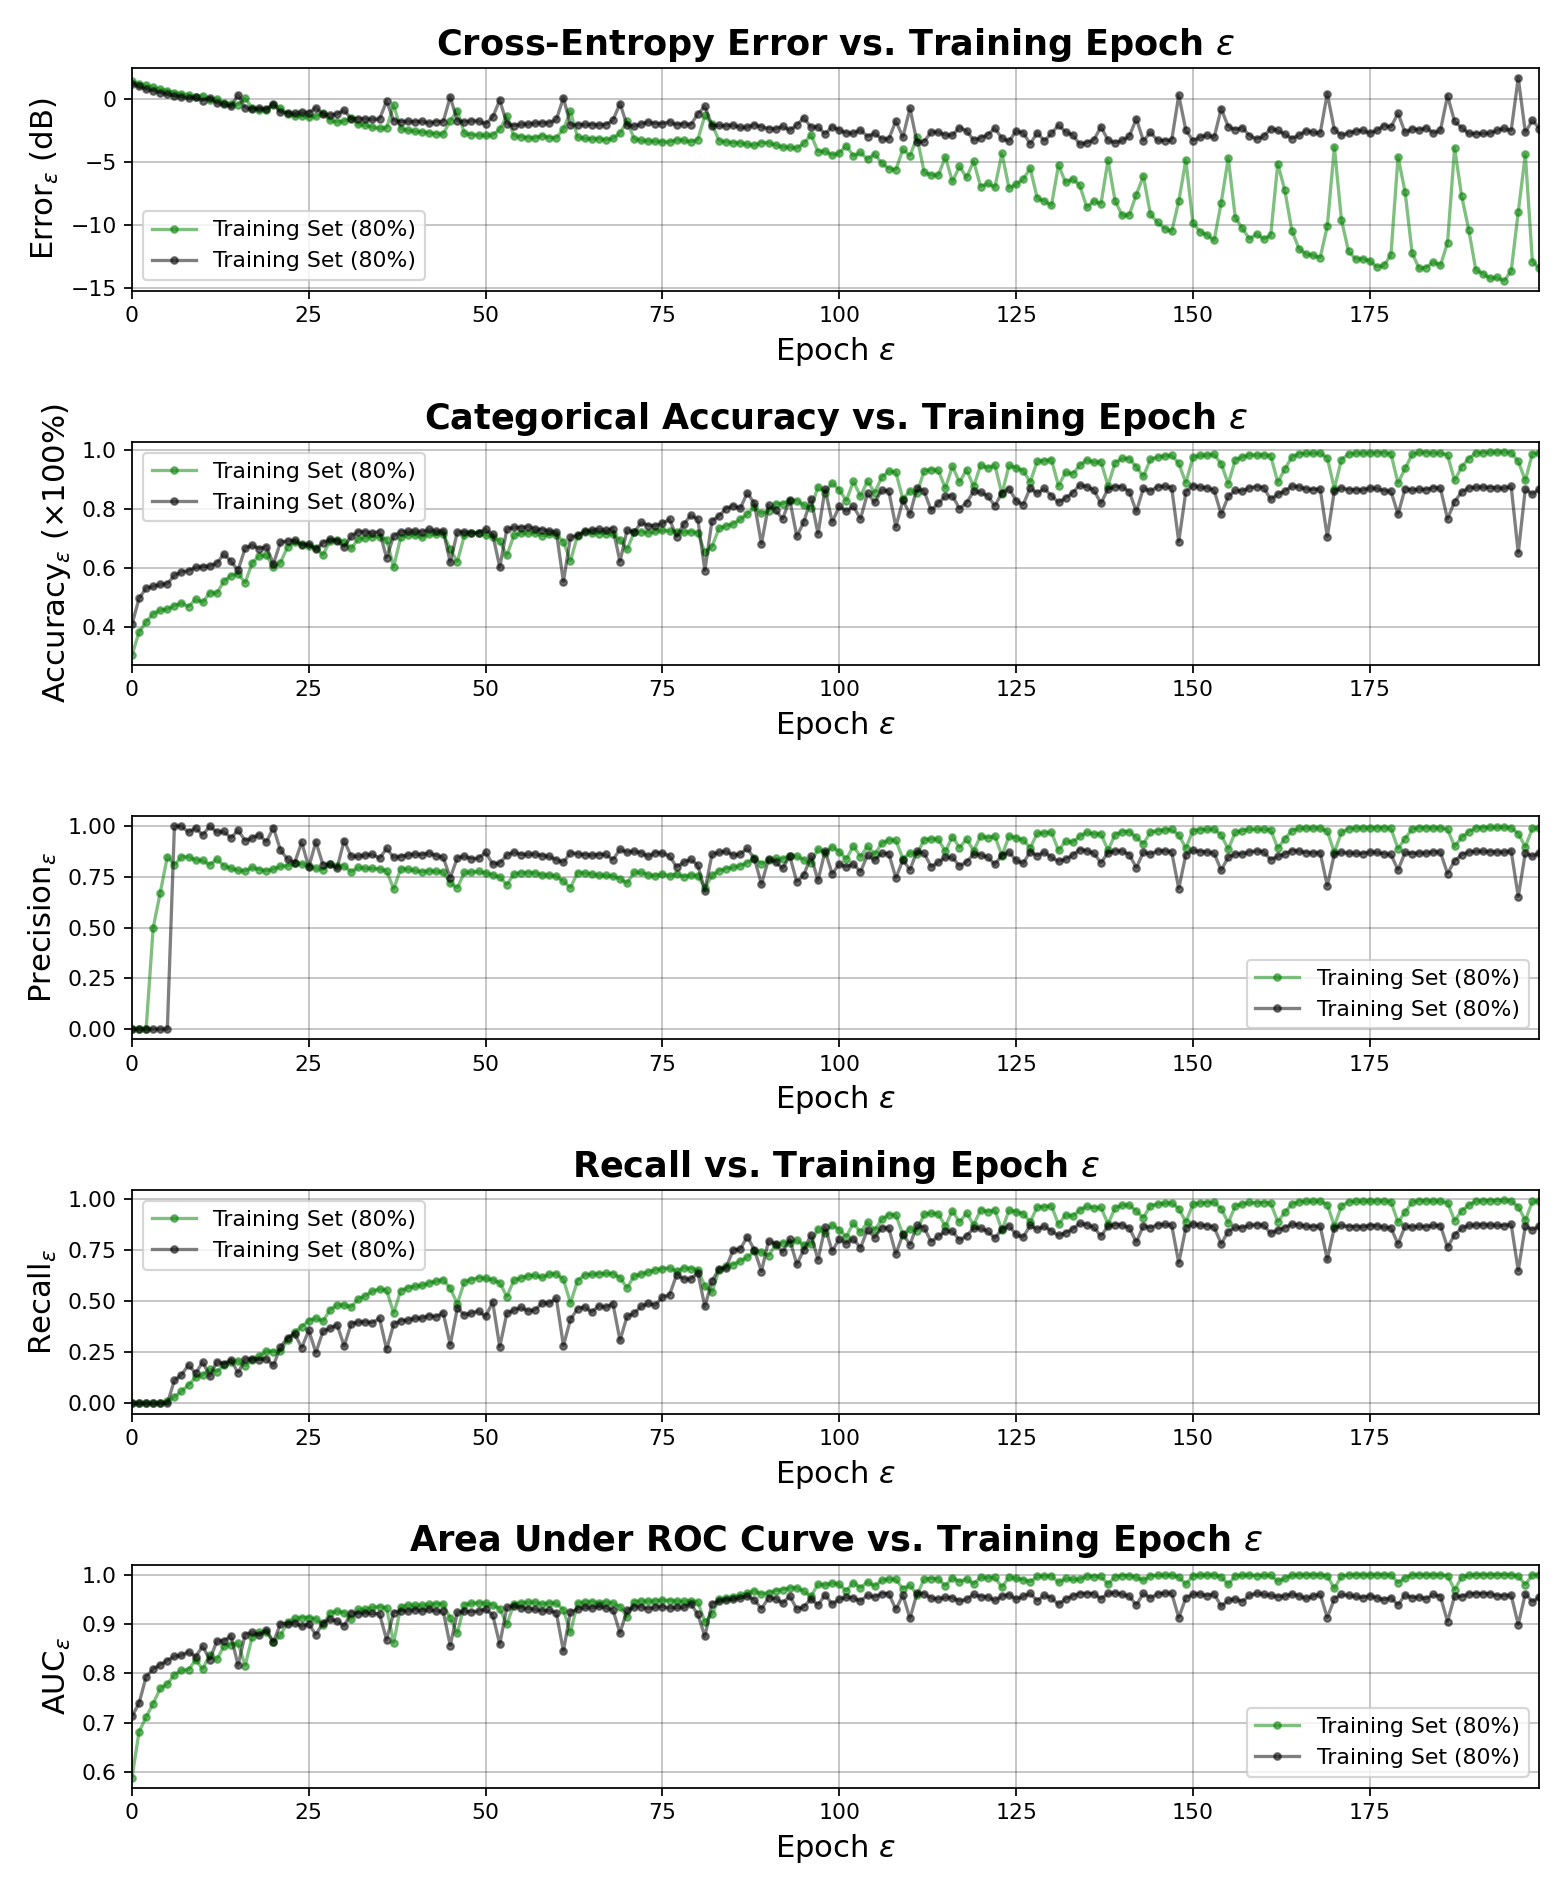

In [10]:
%matplotlib notebook

# Text legend labels for training set curves
train_set_lbl = ('Training Set (' + 
    str(int(100 * (1 - pct_validation))) + '%)');
    
# Text legend labels for validation set curves
val_set_lbl = ('Training Set (' + 
    str(int(100 * (1 - pct_validation))) + '%)');

# New figure
loss_fig = plt.figure(figsize=(9.9,12));

#############
# Loss plot #
#############
ax1 = plt.subplot(5,1,1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Linear grid of training epochs
epochs = arange(0,N_epoch);

# Cross-entropy error (dB) - training set
plt.plot(epochs,10 * log10(
    model.history.history['loss']),
    '.-',c='g',alpha=0.5,
    label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,10 * log10(
    model.history.history['val_loss']),
    '.-',c='k',alpha=0.5,
    label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]);

# Title
plt.title(r'Cross-Entropy Error vs. Training Epoch $\varepsilon$',
          fontsize=16,weight='bold');

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'Error${}_{\varepsilon}$ (dB)',fontsize=14);

# Legend
plt.legend();

#################
# Accuracy plot #
#################
plt.subplot(5,1,2,sharex=ax1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Cross-entropy error (dB) - training set
plt.plot(epochs,model.history.history['categorical_accuracy'],
    '.-',c='g',alpha=0.5,label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,model.history.history['val_categorical_accuracy'],
    '.-',c='k',alpha=0.5,label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]);

# Title
plt.title(r'Categorical Accuracy vs. Training Epoch $\varepsilon$',
          fontsize=16,weight='bold');

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'Accuracy${}_{\varepsilon}$ ($\times100\%$)',fontsize=14);

# Legend
plt.legend();

##################
# Precision plot #
##################
plt.subplot(5,1,3,sharex=ax1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Cross-entropy error (dB) - training set
plt.plot(epochs,model.history.history['precision'],
    '.-',c='g',alpha=0.5,label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,model.history.history['val_precision'],
    '.-',c='k',alpha=0.5,label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]); 

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'Precision${}_{\varepsilon}$',fontsize=14);

# Legend
plt.legend();

###############
# Recall plot #
###############
plt.subplot(5,1,4,sharex=ax1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Cross-entropy error (dB) - training set
plt.plot(epochs,model.history.history['recall'],
    '.-',c='g',alpha=0.5,label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,model.history.history['val_recall'],
    '.-',c='k',alpha=0.5,label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]);

# Title
plt.title(r'Recall vs. Training Epoch $\varepsilon$',
          fontsize=16,weight='bold');

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'Recall${}_{\varepsilon}$',fontsize=14);

# Legend
plt.legend();

############
# AUC plot #
############
plt.subplot(5,1,5,sharex=ax1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Cross-entropy error (dB) - training set
plt.plot(epochs,model.history.history['auc'],
    '.-',c='g',alpha=0.5,label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,model.history.history['val_auc'],
    '.-',c='k',alpha=0.5,label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]);

# Title
plt.title(r'Area Under ROC Curve vs. Training Epoch $\varepsilon$',
          fontsize=16,weight='bold');

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'AUC${}_{\varepsilon}$',fontsize=14);

# Legend
plt.legend();

# Optimize layout
plt.tight_layout();

### $\textbf{Pass Entire Dataset (i.e., Train }\cup\textbf{ Validation) to Model}$

In [11]:
# C x 1 class prediction for entire dataset
Y_hat = model.predict(
    X,                        # Input data
    batch_size=N_batch,       # Batch size
);

# Cast 1-hot class labels as ordinal labels
y_hat = argmax(Y_hat,axis=1); # Predictions
y_true = argmax(Y,axis=1);    # Ground truth

### $\textbf{Confusion Matrix Using Predictions Output Above}$

<IPython.core.display.Javascript object>


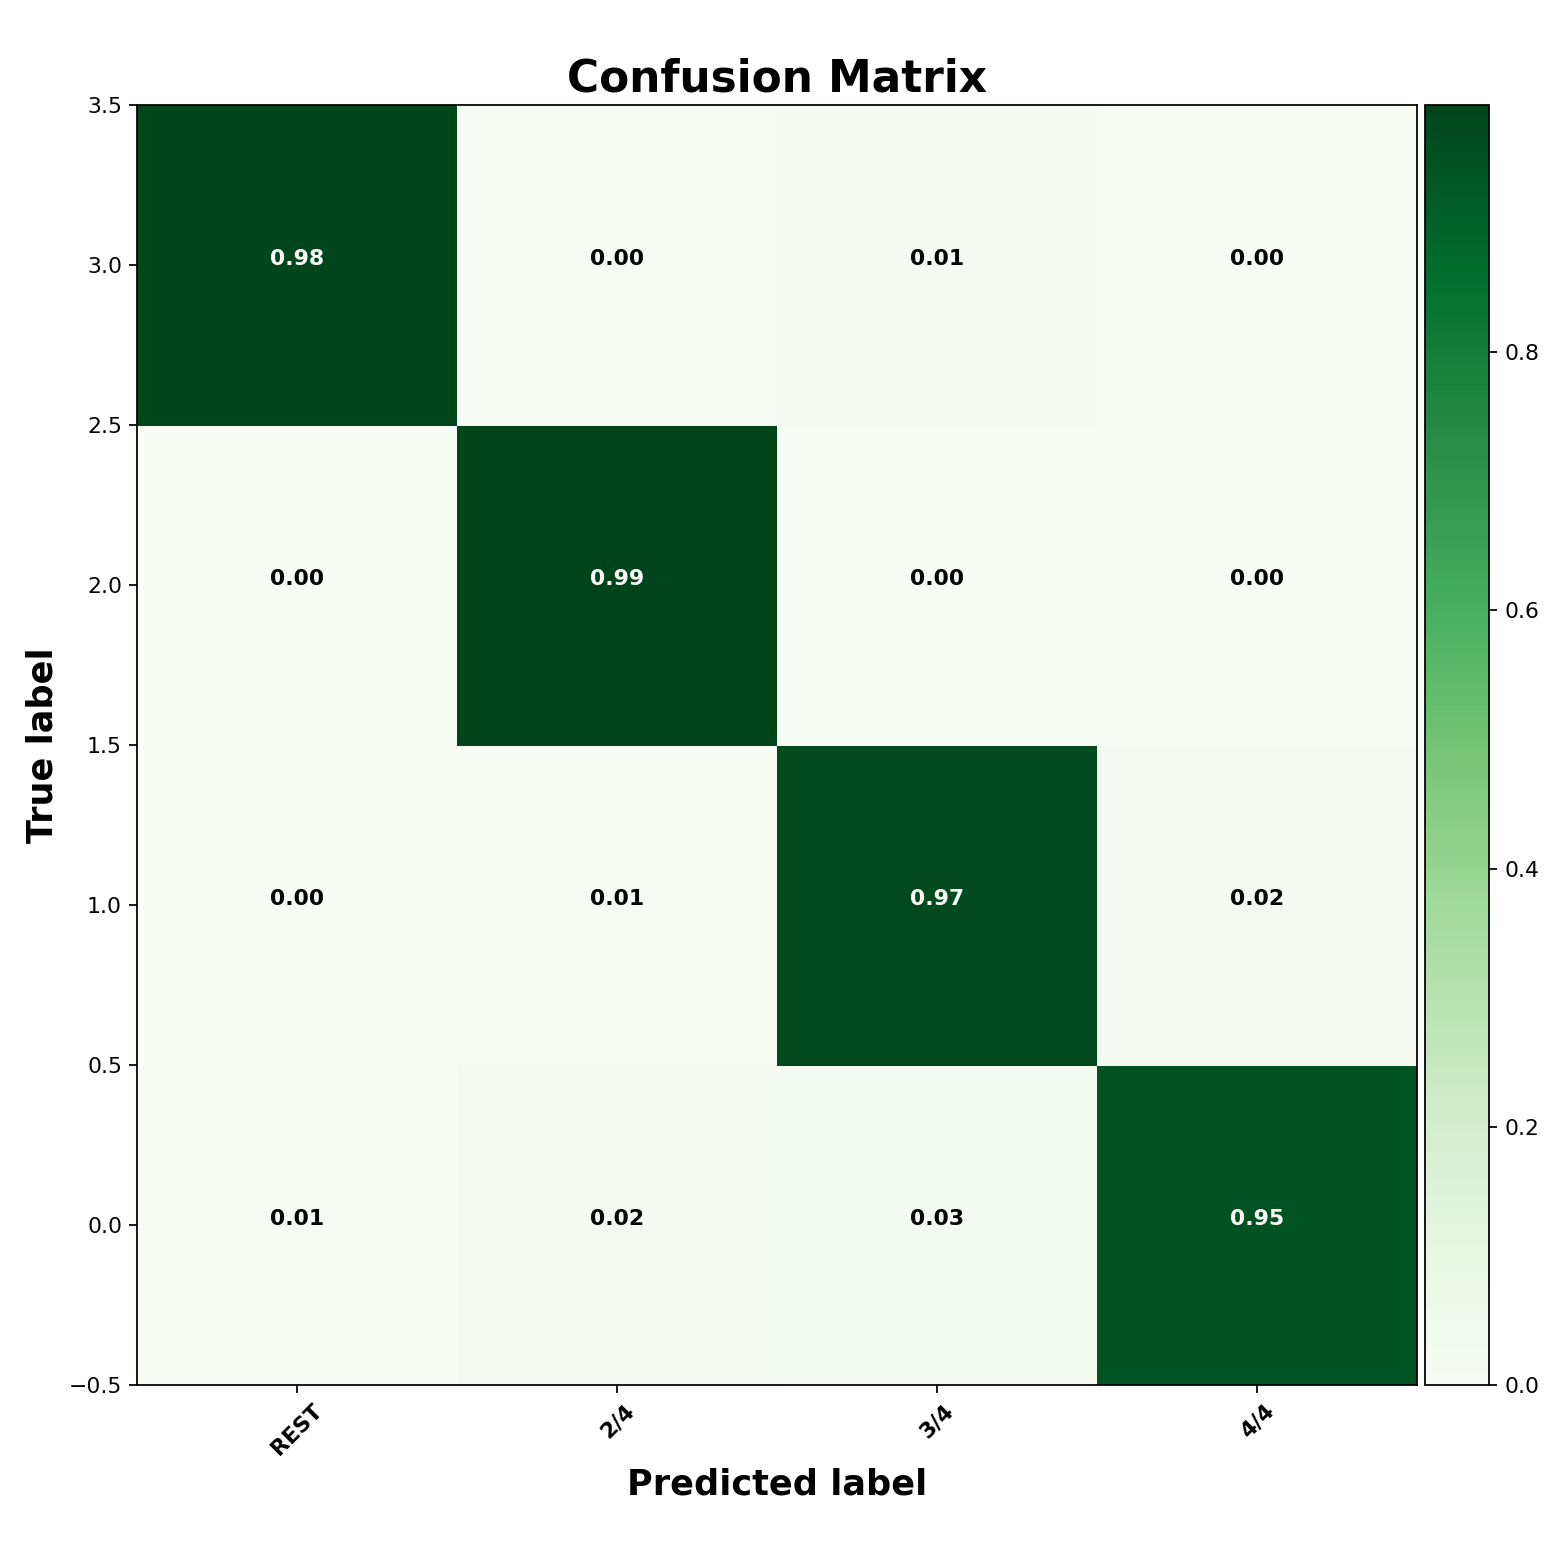

[[9.83212920e-01 4.24989375e-03 1.25371866e-02 0.00000000e+00]
 [3.57398142e-03 9.91422445e-01 3.09745056e-03 1.90612342e-03]
 [3.94477318e-04 5.32544379e-03 9.71597633e-01 2.26824458e-02]
 [5.37719437e-03 2.00854025e-02 2.65696663e-02 9.47967737e-01]]


In [12]:
#########################
#    Compute Matrix:    #
#########################

# Use the sklearn confusion matrix function
confusion_mat = confusion_matrix(y_true,y_hat,
    labels=[c for c in range(C)],sample_weight=None);

#########################
#   Confusion Plotter:  # - adapated from online example
#########################

def plot_confusion_matrix(C,classes,normalize=False,
            title='Confusion matrix',cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    # Let epsilon > 0 be small...
    epsilon = 1e-7;
    
    # Normalization of confusion matrix C
    if normalize:
        C = C.astype('float') / (epsilon + C.sum(axis=1)[:, newaxis]);

    # Print the matrix C
    print(C);
    
    # Image representation
    ax = plt.gca();   # <-- grab current axes
    C = flipud(C);    # <-- flip horizontally for visualization
    im = ax.imshow(C,cmap=cmap);
    
    # Colorbar
    colorbar(im);
    
    # Title
    plt.title(title,fontsize=20,weight="bold");
    
    # Tick labels
    tick_marks = arange(len(classes));
    plt.xticks(tick_marks, classes, rotation=45,fontweight="bold");
    
    # Overwrite default y-axis limits
    plt.ylim([-0.5,len(classes)-0.5]);

    # Text labels in tiles (i.e., elements)
    fmt = '.2f' if normalize else 'd'
    thresh = C.max() / 2.
    for i, j in iter_prod(range(C.shape[0]), range(C.shape[1])):
        plt.text(j, i, format(C[i, j], fmt),
                 horizontalalignment="center",weight="bold",
                 color="white" if C[i, j] > thresh else "black")

    # x-axis labels
    plt.ylabel('True label',fontsize=16,weight="bold");
    
    # y-axis labels
    plt.xlabel('Predicted label',fontsize=16,weight="bold");
    
    # Set axis layout
    plt.tight_layout();
    
#########################
#    Scale Colorbar:    # - found this online
#########################

def colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

#########################
#    Visualization:     #
#########################

conf_fig = plt.figure(figsize=(9.9,9.9));
plot_confusion_matrix(
    confusion_mat, 
    classes=[clss for clss in class_table],
    normalize=True,
    title='Confusion Matrix',
    cmap=plt.cm.Greens);